In [1]:
%matplotlib inline
import matplotlib.pylab as plt

import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.optimizers import Adam, Adagrad, Adadelta, SGD
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.callbacks  import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout, BatchNormalization, ReLU, LeakyReLU
from tensorflow.keras.layers import RepeatVector, Flatten, Conv1D, UpSampling1D, MaxPooling1D, Reshape, Permute

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

In [15]:
%%time
train_y = pd.read_parquet('../data/graphs.train.parquet')
train_x   = pd.read_parquet('../data/params.train.parquet')

val_y = pd.read_parquet('../data/graphs.val.parquet', )
val_x = pd.read_parquet('../data/params.val.parquet', )

test_y  = pd.read_parquet('../data/graphs.test.parquet')
test_x = pd.read_parquet('../data/params.test.parquet')

ext_y  = pd.read_parquet('../data/graphs.ext.parquet')
ext_x = pd.read_parquet('../data/params.ext.parquet')

CPU times: user 671 ms, sys: 691 ms, total: 1.36 s
Wall time: 1.36 s


In [14]:
raw_test_y  = pd.read_parquet('../data/raw.graphs.test.parquet')
raw_test_y

,col_40,col_46,col_47
index,,,
0,580.440002,8.5661,630.299988
1,580.090027,8.5661,628.840027
2,579.729980,8.5661,628.739990
3,579.659973,8.5661,628.549988
4,579.729980,8.5661,628.559998
...,...,...,...
9995,485.589996,6.7822,488.179993
9996,485.589996,6.7835,488.170013
9997,485.579987,6.7835,488.160004


In [11]:
train_y.head()

,col_40,col_46,col_47
index,,,
0,0.995508,1.0,0.122066
1,0.993052,1.0,0.121121
2,0.990525,1.0,0.121057
3,0.990033,1.0,0.120934
4,0.990525,1.0,0.120940


In [12]:
train_x.head()

,param_1,param_2,param_3,param_4,param_5,param_6,param_7,param_8,loca_type
name,,,,,,,,,
1.0inch-#2000_csv_Run-1978,0.202015,0.202015,0.399885,0.600115,0.620863,0.160431,0.160431,0.0,1.0
0.5inch-#2000_csv_Run-1675,0.240198,0.240198,0.642439,0.357560,0.815345,0.179042,0.179042,0.0,0.5
1.0inch-#2000_csv_Run-1806,0.286265,0.286265,0.701312,0.298688,0.852294,0.215236,0.215236,0.0,1.0
1.5inch-#2000_csv_Run-1891,0.226914,0.226914,0.287934,0.712066,0.498429,0.065139,0.065139,0.0,1.5
1.5inch-#2000_csv_Run-478,0.277137,0.277138,0.461141,0.538859,0.677740,0.063758,0.063758,0.0,1.5


In [3]:
def append_locatype(df):
    df['loca_type']=df.index.str[:3]#.map(np.float32)
    return df.astype(np.float32)

train_x=append_locatype(train_x)
val_x=append_locatype(val_x)
test_x=append_locatype(test_x)
ext_x=append_locatype(ext_x)

In [4]:
trainset = tf.data.Dataset.from_tensor_slices((train_x.values, train_y.values.reshape(-1, 10000, 3)))
valset = tf.data.Dataset.from_tensor_slices((val_x.values, val_y.values.reshape(-1, 10000, 3)))
testset = tf.data.Dataset.from_tensor_slices((test_x.values, test_y.values.reshape(-1, 10000, 3)))
extset = tf.data.Dataset.from_tensor_slices((ext_x.values, ext_y.values.reshape(-1, 10000, 3)))

In [13]:
[(x,y)]=testset.take(1)
x

<tf.Tensor: id=12136, shape=(9,), dtype=float32, numpy=
array([0.12591137, 0.12591138, 0.5129608 , 0.48703885, 0.7213182 ,
       0.12588005, 0.12588002, 0.        , 1.        ], dtype=float32)>

In [5]:
model = Sequential([
    Dense(100),
    ReLU(),
    Dense(1000),
    ReLU(),
    Dense(30000),
    Reshape((10000,3)),
])

In [6]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

optimizer = Adam()
loss = MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)
model.fit(trainset.shuffle(buffer_size=1000).batch(50),
          epochs=500,
          callbacks=[early_stopping],
          validation_data=valset.batch(20)
         )

Epoch 1/500
95/95 [==============================] - 2s 18ms/step - loss: 0.0487 - val_loss: 0.0000e+00
Epoch 2/500
95/95 [==============================] - 1s 11ms/step - loss: 0.0018 - val_loss: 9.6839e-04
Epoch 3/500
95/95 [==============================] - 1s 11ms/step - loss: 7.5195e-04 - val_loss: 6.1184e-04
Epoch 4/500
95/95 [==============================] - 1s 11ms/step - loss: 5.4053e-04 - val_loss: 5.1953e-04
Epoch 5/500
95/95 [==============================] - 1s 11ms/step - loss: 4.7278e-04 - val_loss: 4.5061e-04
Epoch 6/500
95/95 [==============================] - 1s 11ms/step - loss: 4.1301e-04 - val_loss: 4.0683e-04
Epoch 7/500
95/95 [==============================] - 1s 11ms/step - loss: 3.6167e-04 - val_loss: 3.5333e-04
Epoch 8/500
95/95 [==============================] - 1s 11ms/step - loss: 3.1598e-04 - val_loss: 3.1773e-04
Epoch 9/500
95/95 [==============================] - 1s 11ms/step - loss: 2.7773e-04 - val_loss: 2.7854e-04
Epoch 10/500
95/95 [================

In [7]:
# xs,ys=train_x, train_y
xs,ys=test_x, test_y
test_pred=model.predict(xs.values)
test_real=ys.values.reshape(-1,10000,3)
test_err = test_real - test_pred
np.abs(test_err**2).mean()

8.983772e-05

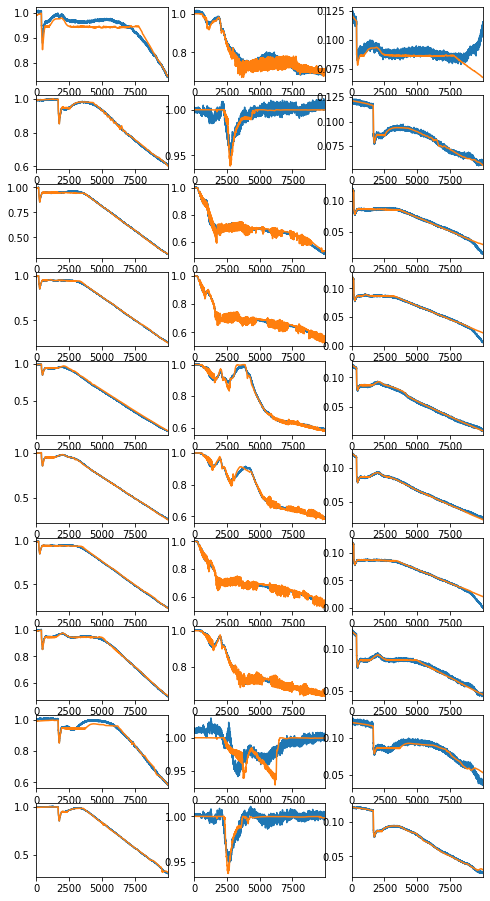

In [8]:
fig, axess = plt.subplots(10,3, figsize=(8,16))

offset=20
for idx,axes in enumerate(axess):
    idx += offset
    df_pred=pd.DataFrame(test_pred[idx])
    df_y=pd.DataFrame(ys.values.reshape(-1,10000,3)[idx])

    for col, ax in enumerate(axes):
        df_pred[col].plot(ax=ax)
        df_y[col].plot(ax=ax)

In [9]:
xs,ys=ext_x, ext_y
ext_pred=model.predict(xs.values)
ext_real=ys.values.reshape(-1,10000,3)
test_err = ext_real - ext_pred
np.abs(test_err**2).mean()

0.0030519476

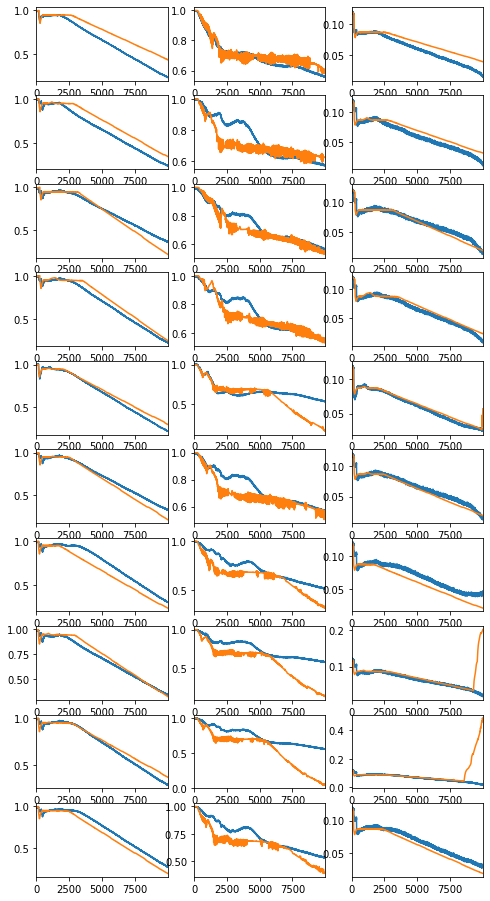

In [10]:
fig, axess = plt.subplots(10,3, figsize=(8,16))

offset=45
for idx,axes in enumerate(axess):
    df_pred=pd.DataFrame(ext_pred[idx+offset])
    df_y=pd.DataFrame(ys.values.reshape(-1,10000,3)[idx])

    for col, ax in enumerate(axes):
        df_pred[col].plot(ax=ax)
        df_y[col].plot(ax=ax)